In [372]:
include("utils/GlobalUsings.jl")
include("utils/DataLoader.jl")
include("Lib/CustomDiffLib.jl")
include("utils/NetFunctions.jl")
include("nets/netFlux.jl")
include("utils/Ploter.jl")

plotTestAccuracty (generic function with 1 method)

In [373]:
X_train, y_train, X_test, y_test, classes  = getPrepearedData()

([1.009014199843616 -1.2420155219210052 … -1.360490770434932 -0.17573828529565805; 0.13034108240733125 -0.10310563235206699 … 0.3637877971667295 -1.0368924913896589; 0.5103429470982649 -1.3557309868898528 … -1.2426355969511789 -0.16822939253377794; 0.38049108231268275 -1.193954775532902 … -1.3251585970200344 -0.2755280251229776], Bool[0 1 … 1 0; 1 0 … 0 1; 0 0 … 0 0], [0.2981627087600509 1.601390442413253 … -0.53116403083744 1.009014199843616; -0.5699990618708635 1.2975746562043213 … 1.997914800482515 0.5972345119261266; 0.11450908231290653 1.3020106766689812 … -1.4122786818591897 1.075819896791634; 0.11808343933841868 1.6925292971840036 … -1.06275095404577 1.6925292971840036], Bool[0 0 … 1 0; 1 0 … 0 0; 0 1 … 0 1], ["setosa", "versicolor", "virginica"])

In [374]:
fluxNet, opt, loss, params = getDefaultFlux()
fluxLossHistory, fluxAccuracyHistory = train(fluxNet, params, X_train, y_train, 100, opt, loss)

([6.042839658012769, 6.019717393469605, 5.998433897620042, 5.979937154476092, 5.963126272155207, 5.947752437528251, 5.933638830193688, 5.919720749428539, 5.906452186203841, 5.891749714832374  …  5.410287876894098, 5.4074473179412825, 5.404659597971597, 5.401949007702057, 5.399313388384716, 5.39669055293464, 5.39401813779023, 5.391272501259625, 5.388417954534707, 5.385557619278237], [0.2, 0.26666666666666666, 0.3, 0.3, 0.3333333333333333, 0.36666666666666664, 0.4, 0.4, 0.43333333333333335, 0.4666666666666667  …  0.7, 0.7, 0.7333333333333333, 0.7333333333333333, 0.7666666666666667, 0.7666666666666667, 0.7666666666666667, 0.7666666666666667, 0.7666666666666667, 0.7666666666666667])

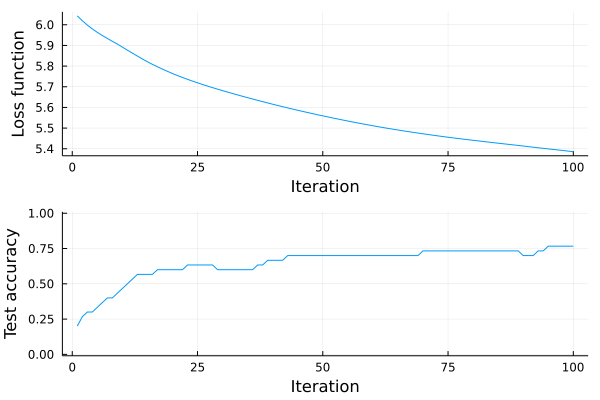

In [375]:
plotLossAccuracu(fluxLossHistory, fluxAccuracyHistory)

In [376]:
include("nets/NetAnia.jl")
aniaNet = getDefaultAniaNet()
aniaLossHistory, AniaAccHistory = trainAnia(aniaNet, X_train, y_train, 5, 0.01)
acc_history, acc_val = accuracy(aniaNet, X_test, y_test)

([0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0], 33.33333333333333)

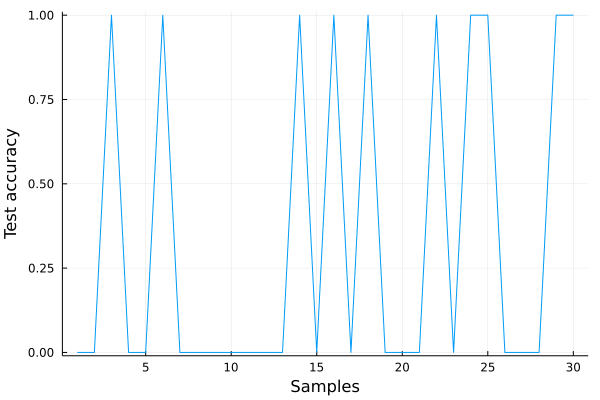

In [377]:
plotLossAccuracu(aniaLossHistory, AniaAccHistory)
plotTestAccuracty(acc_history)

In [378]:
include("nets/netSebastian.jl")
sebastianNet = getSebastianDefaultNet()
Loss, acc = trainSebastian(sebastianNet, X_train, y_train, 5, 0.01)

([0.20449939459171315, 0.20036334898182362, 0.19707621506796552, 0.19434732926171072, 0.19199107547190492], [0.4861527926641233, 0.49016946706478665, 0.49016946706478665, 0.4919520370144726, 0.4919520370144726])

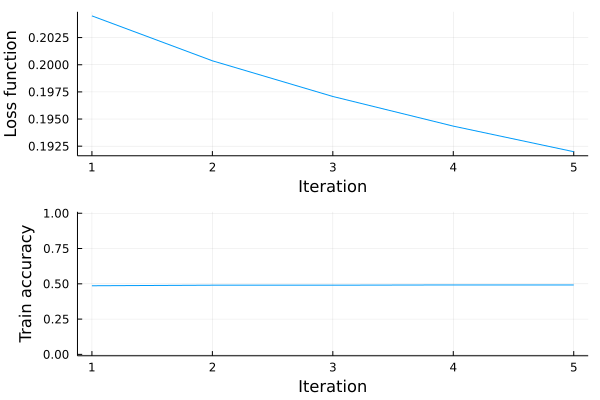

In [381]:
plotLossAccuracy(Loss, acc)

In [380]:
accuracySebastian(network, X_test, y_test)